<a href="https://colab.research.google.com/github/mmonch/Sidecar_Project/blob/main/notebooks/Sidecar_Project_lstm_seq2seq_model_reduced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-level recurrent sequence-to-sequence model

Source: https://keras.io/examples/nlp/lstm_seq2seq/

## Setup

In [1]:
!pip install contractions
!pip install fuzzywuzzy[speedup]

     |████████████████████████████████| 284 kB 4.2 MB/s 
     |████████████████████████████████| 321 kB 79.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85440 sha256=c2616ddacbd02063a85aa1462c950cd112fca63ec62d868a46deb0be7e20462b
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 50 kB 2.7 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149862 sha256=8ec06bafb9342c2203a92f11b5a74f7ed70bc89aa68e9bb19a8b81b5cbbe4d4a
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


In [2]:
# nlp packages
import re
import unicodedata
import contractions
import spacy
import nltk
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# progressbar
import tqdm

# general packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Deeplearing
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
# fix random seed for reproducibility
seed = 42

# for numpy
np.random.seed(seed)
# for tenserflow.keras
tf.random.set_seed(seed)

## Download the data

In [ ]:
# upload file from local directory
# from google.colab import files
# files.upload()

In [ ]:
# data = pd.read_csv("Sidecar_Data_Sample.csv")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data = pd.read_csv("gdrive/My Drive/SIDECAR_P/Sidecar_Data_Sample.csv")

In [6]:
top_n= data.Attribute_Business_Name.value_counts()[:100]
top_n_df = data[data['Attribute_Business_Name'].map(data['Attribute_Business_Name'].value_counts()).isin(top_n)]

In [7]:
len(data['Attribute_Business_Name'].unique())

2099

In [8]:
len(top_n_df['Attribute_Business_Name'].unique())

115

In [9]:
len(top_n)

100

In [10]:
len(top_n_df)

1343

In [11]:
# if I wanted to run it with only the top 100 hard stop --> .index method
# len(data[data['Attribute_Business_Name'].isin(data['Attribute_Business_Name'].value_counts()[:100].index)])

## Train Test Split

In [12]:
train, test = train_test_split(top_n_df, test_size=0.2, random_state=42, stratify=top_n_df["Attribute_Business_Name"])

In [13]:
print("Length of Training Set: " + str(len(train)), "\nLength of Test Set: " + str(len(test)))

Length of Training Set: 1074 
Length of Test Set: 269


In [14]:
print(train.Attribute_Business_Name.value_counts(), test.Attribute_Business_Name.value_counts())

Date and time the record was last updated.    56
Last modified date                            46
Last modified by                              41
Last Edited By                                39
Valid from                                    30
                                              ..
Discussion Object Id                           5
Sponsor id                                     5
Total amount excluding tax                     5
Full name for this person                      5
Total amount of tax                            5
Name: Attribute_Business_Name, Length: 115, dtype: int64 Date and time the record was last updated.                                              14
Last modified date                                                                      12
Last modified by                                                                        11
Last Edited By                                                                          10
Valid from                              

## Configurations

In [15]:
# for plotting
plt.style.use("seaborn")

In [16]:
# for lstm seq 2 seq model
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Prepare the data

### Preprocess and normalize the data


In [17]:
# preprocess and normalize Text

# in case text not english
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# preprocessing
def pre_process_text(labels):
  norm_docs = []
  for string in tqdm.tqdm(labels):
    string = string.replace("_", " ")
    string = string.translate(string.maketrans("\n\t\r", "   "))
    string = remove_accented_chars(string) 
    # and inset a space where a number follows a letter et vice versa
    string = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', string)
    # insert space where an uppercase letter follows a lowercase letter
    string = re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", string)
    string = contractions.fix(string)
    # where XXXX number to XXXX number replace - with to IN PROGRESS
    string = string.replace("-", " to ")
    # remove special characters or whitespaces
    string = re.sub(r"[^a-zA-Z0-9\s]", "", string, flags=re.I|re.A)
    string = string.lower()
    string = string.strip()
    # string = string.split(" ")
    norm_docs.append(string)
  return norm_docs

# lemamtization

#def spacy_lemmatize_text(text):
    #text = nlp(text)
    #text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    #return text

### Vectorize the Data

In [18]:
# vectorize the data

input_texts = pre_process_text(train["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(train["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 1074/1074 [00:00<00:00, 53722.47it/s]

Number of samples: 1074
Number of unique input tokens: 36
Number of unique output tokens: 32
Max sequence length for inputs: 36
Max sequence length for outputs: 94


In [19]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [20]:
METRICS = [
  "accuracy",
]


In [21]:
model.compile(
    optimizer="rmsprop", 
    loss="categorical_crossentropy", 
    metrics=METRICS
)

mc = keras.callbacks.ModelCheckpoint(
    'my_nmt_model_min_loss.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[mc, es]
)

# Save model
model.save("lstm_s2s_v1")

Epoch 1/200
13/14 [==========================>...] - ETA: 0s - loss: 1.3685 - accuracy: 0.7364
Epoch 00001: val_loss improved from inf to 0.89477, saving model to my_nmt_model_min_loss.h5
14/14 [==============================] - 8s 100ms/step - loss: 1.3541 - accuracy: 0.7385 - val_loss: 0.8948 - val_accuracy: 0.8005
Epoch 2/200
14/14 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.8024
Epoch 00002: val_loss improved from 0.89477 to 0.87091, saving model to my_nmt_model_min_loss.h5
14/14 [==============================] - 0s 19ms/step - loss: 0.8935 - accuracy: 0.8024 - val_loss: 0.8709 - val_accuracy: 0.8009
Epoch 3/200
11/14 [======================>.......] - ETA: 0s - loss: 0.8578 - accuracy: 0.8034
Epoch 00003: val_loss did not improve from 0.87091
14/14 [==============================] - 0s 15ms/step - loss: 0.8667 - accuracy: 0.8027 - val_loss: 0.8820 - val_accuracy: 0.7995
Epoch 4/200
11/14 [======================>.......] - ETA: 0s - loss: 0.8667 - accur

INFO:tensorflow:Assets written to: lstm_s2s_v1/assets


INFO:tensorflow:Assets written to: lstm_s2s_v1/assets


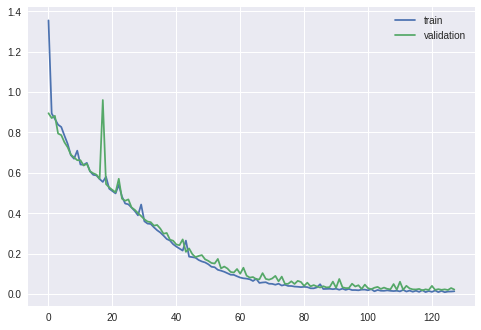

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

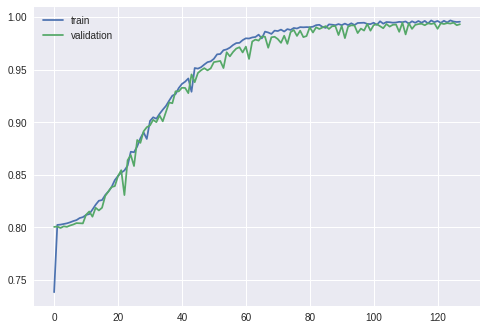

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

## Run Inference on a sample (n=20) of the Training Data

In [24]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("lstm_s2s_v1")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [25]:
true_target_texts = [string.replace("\t","").replace("\n","") for string in target_texts]

In [26]:
def get_fuzzy_scores(input_seq):
  input_sentence = input_texts[seq_index]
  decoded_sentence = decode_sequence(input_seq)
  true_target_sentence = true_target_texts[seq_index]
  fuzzy_partial_ratio = fuzz.partial_ratio(decoded_sentence, true_target_texts[seq_index])
  return input_sentence, decoded_sentence, true_target_sentence, fuzzy_partial_ratio

In [59]:
# list version
results = []
for seq_index in tqdm.tqdm(range(1074)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    new_list = []
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    new_list.append(input_texts[seq_index])
    new_list.append(decoded_sentence.replace("\n",""))
    new_list.append(true_target_texts[seq_index])
    new_list.append(fuzz.ratio(decoded_sentence, true_target_texts[seq_index]))
    new_list.append(fuzz.partial_ratio(decoded_sentence, true_target_texts[seq_index]))
    new_list.append(fuzz.token_sort_ratio(decoded_sentence, true_target_texts[seq_index]))
    results.append(new_list)

100%|██████████| 1074/1074 [17:19<00:00,  1.03it/s]


In [ ]:
results

In [104]:
fuzzy_train_df = pd.DataFrame(results, columns=[
                                          "Input", 
                                          "Predicted_Output", 
                                          "Target_Output", 
                                          "Fuzzy_Ratio",
                                          "Fuzzy_Partial_Ratio",
                                          "Fuzzy_Token_Sort_Ratio"]
                        )

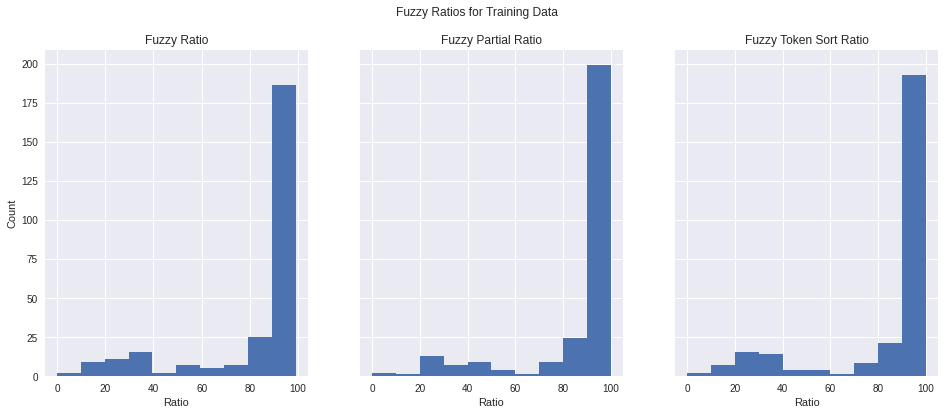

In [103]:
# define subplot axes
fig, (axs) = plt.subplots(nrows=1, ncols=3, sharey=True)

# set figure title
fig.suptitle('Fuzzy Ratios for Training Data')

# plot histograms
axs[0].hist(fuzzy_train_df["Fuzzy_Ratio"])
axs[1].hist(fuzzy_train_df["Fuzzy_Partial_Ratio"])
axs[2].hist(fuzzy_train_df["Fuzzy_Token_Sort_Ratio"])

# set plot titles
axs[0].set_title('Fuzzy Ratio')
axs[1].set_title('Fuzzy Partial Ratio')
axs[2].set_title('Fuzzy Token Sort Ratio')

# set labels
plt.setp(axs, xlabel='Ratio')
plt.setp(axs[0], ylabel='Count')
fig.set_size_inches(16,6)

In [61]:
fuzzy_train_df["Fuzzy_Partial_Ratio"].describe()

count    1074.000000
mean       88.211359
std        23.628040
min         0.000000
25%        88.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: Fuzzy_Partial_Ratio, dtype: float64

In [62]:
print("Average Partial Fuzzy Ratio:", fuzzy_df["Fuzzy_Partial_Ratio"].mean())
print("Median Partial Fuzzy Ratio:", fuzzy_df["Fuzzy_Partial_Ratio"].median())
print("Partial Fuzzy Ratio Mode:", fuzzy_df["Fuzzy_Partial_Ratio"].mode())

Average Partial Fuzzy Ratio: 88.21135940409684
Median Partial Fuzzy Ratio: 100.0
Partial Fuzzy Ratio Mode: 0    100
dtype: int64


find perfect matches

Run Inference on a sample (n=20) of the Test Data

In [64]:
# vectorize the data
input_texts = pre_process_text(test["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(test["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 269/269 [00:00<00:00, 54635.02it/s]

Number of samples: 269
Number of unique input tokens: 36
Number of unique output tokens: 32
Max sequence length for inputs: 35
Max sequence length for outputs: 94


In [65]:
score, acc = model.evaluate(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

5/5 [==============================] - 1s 11ms/step - loss: 0.0116 - accuracy: 0.9962
Test score: 0.011617815122008324
Test accuracy: 0.9961639046669006


In [66]:
true_target_texts = [string.replace("\t","").replace("\n","") for string in target_texts]

In [67]:
# list version
results = []
for seq_index in tqdm.tqdm(range(269)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    new_list = []
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    new_list.append(input_texts[seq_index])
    new_list.append(decoded_sentence.replace("\n",""))
    new_list.append(true_target_texts[seq_index])
    new_list.append(fuzz.ratio(decoded_sentence, true_target_texts[seq_index]))
    new_list.append(fuzz.partial_ratio(decoded_sentence, true_target_texts[seq_index]))
    new_list.append(fuzz.token_sort_ratio(decoded_sentence, true_target_texts[seq_index]))
    results.append(new_list)

100%|██████████| 269/269 [04:19<00:00,  1.04it/s]


In [118]:
fuzzy_test_df = pd.DataFrame(results, columns=[
                                          "Input", 
                                          "Predicted_Output", 
                                          "Target_Output", 
                                          "Fuzzy_Ratio",
                                          "Fuzzy_Partial_Ratio",
                                          "Fuzzy_Token_Sort_Ratio"]
                        )

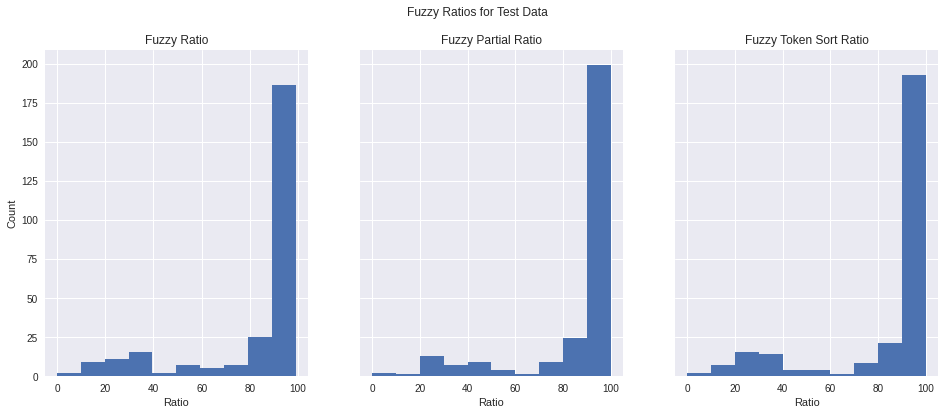

In [105]:
# define subplot axes
fig, (axs) = plt.subplots(nrows=1, ncols=3, sharey=True)

# set figure title
fig.suptitle('Fuzzy Ratios for Test Data')

# plot histograms
axs[0].hist(fuzzy_test_df["Fuzzy_Ratio"])
axs[1].hist(fuzzy_test_df["Fuzzy_Partial_Ratio"])
axs[2].hist(fuzzy_test_df["Fuzzy_Token_Sort_Ratio"])

# set plot titles
axs[0].set_title('Fuzzy Ratio')
axs[1].set_title('Fuzzy Partial Ratio')
axs[2].set_title('Fuzzy Token Sort Ratio')

# set labels
plt.setp(axs, xlabel='Ratio')
plt.setp(axs[0], ylabel='Count')
fig.set_size_inches(16,6)

overall very good performance.

- fuzz ratio returns 100% only when there is an exact match.
- fuzz partial ratio checks if either of the strings is a sub string of the other. 
- fuzzy token sort ration ignores punctuation and ignores the order of the words in a string.
- token_set_ratio() takes a more flexible approach than token_sort_ratio(). Instead of just tokenizing the strings, sorting and then pasting the tokens back together, token_set_ratio performs a set operation that takes out the common tokens (the intersection) and then makes fuzz.ratio(). Extra or same repeated words do not matter.

In [114]:
print("Average Fuzzy Ratio:", fuzzy_test_df["Fuzzy_Ratio"].mean())
print("Median Fuzzy Ratio:", fuzzy_test_df["Fuzzy_Ratio"].median())
print("Fuzzy Ratio Mode:", fuzzy_test_df["Fuzzy_Ratio"].mode())

Average Fuzzy Ratio: 82.85873605947955
Median Fuzzy Ratio: 96.0
Fuzzy Ratio Mode: 0    97
dtype: int64


In [106]:
fuzzy_test_df["Fuzzy_Ratio"].describe()

count    269.000000
mean      82.858736
std       25.480797
min        0.000000
25%       80.000000
50%       96.000000
75%       97.000000
max       99.000000
Name: Fuzzy_Ratio, dtype: float64

let's take a look at the highest quantile ratios:



In [116]:
fuzzy_test_df[fuzzy_test_df.Fuzzy_Ratio > fuzzy_test_df.Fuzzy_Ratio.quantile(.75)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
1,attribute business rule,attribute business rule,attribute business rule,98,100,100
6,total including tax,total amount including tax,total amount including tax,98,100,100
10,full name,full name for this person,full name for this person,98,100,100
19,rowguid,rowguidcol number uniquely identifying the rec...,rowguidcol number uniquely identifying the rec...,99,100,100
20,modified date,date and time the record was last updated,date and time the record was last updated,99,100,100
21,modified date,date and time the record was last updated,date and time the record was last updated,99,100,100
24,discussion object id,discussion object id,discussion object id,98,100,100
25,rowguid,rowguidcol number uniquely identifying the rec...,rowguidcol number uniquely identifying the rec...,99,100,100
26,rowguid,rowguidcol number uniquely identifying the rec...,rowguidcol number uniquely identifying the rec...,99,100,100
31,sales territory,sales territory for this state province,sales territory for this state province,99,100,100


In [126]:
fuzzy_test_df[fuzzy_test_df.Fuzzy_Partial_Ratio > fuzzy_test_df.Fuzzy_Partial_Ratio.quantile(.15)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
1,attribute business rule,attribute business rule,attribute business rule,98,100,100
3,visit detail id,visit detail id,visit detail id,97,100,100
4,country region name,country region name,country region name,97,100,100
5,valid from,valid from,valid from this date and time,50,91,51
6,total including tax,total amount including tax,total amount including tax,98,100,100
...,...,...,...,...,...,...
264,valid to,valid to,valid to,94,100,100
265,valid to,valid to,valid to,94,100,100
266,classification attribute id,classification id,classification attribute id,76,83,77
267,last edited by,last edited by,last edited by,97,100,100


let's take a look at the lowest quantile ratios:

find all instances where the model doesn't perform well
- check value_coutns
- check sequence lengths

In [110]:
fuzzy_test_df[fuzzy_test_df.Fuzzy_Ratio < fuzzy_test_df.Fuzzy_Ratio.quantile(.25)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
0,asset database,attribute id,database,38,38,40
2,domain name,domain id,domain name,67,70,70
5,valid from,valid from,valid from this date and time,50,91,51
9,domain name,domain id,domain name,67,70,70
17,domain status id,domain id,status id,42,44,22
18,attribute status id,attribute id,status id,55,44,29
23,attribute sample data,is nullable,attribute sample data,30,42,31
29,state province id,state province name,numeric id used for reference to a state or pr...,39,75,40
30,p af 189358,unit,body site,29,40,31
37,domain sme contact info,domain id,sme contact,19,20,30


In [107]:
fuzzy_test_df["Fuzzy_Partial_Ratio"].describe()

count    269.000000
mean      88.609665
std       23.410995
min        0.000000
25%       88.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: Fuzzy_Partial_Ratio, dtype: float64

In [111]:
fuzzy_test_df[fuzzy_test_df.Fuzzy_Partial_Ratio < fuzzy_test_df.Fuzzy_Partial_Ratio.quantile(.25)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
0,asset database,attribute id,database,38,38,40
2,domain name,domain id,domain name,67,70,70
8,attribute business name,attribute business rule,attribute business name,85,87,87
9,domain name,domain id,domain name,67,70,70
17,domain status id,domain id,status id,42,44,22
18,attribute status id,attribute id,status id,55,44,29
23,attribute sample data,is nullable,attribute sample data,30,42,31
29,state province id,state province name,numeric id used for reference to a state or pr...,39,75,40
30,p af 189358,unit,body site,29,40,31
37,domain sme contact info,domain id,sme contact,19,20,30
